In [ ]:
#imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub


c:\Users\Hp\Documents\GitHub\Breast-canser_screening\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")
print("Dataset:", path)


100%|██████████| 786M/786M [01:15<00:00, 10.9MB/s] 

Extracting files...


Dataset: C:\Users\Hp\.cache\kagglehub\datasets\nodoubttome\skin-cancer9-classesisic\versions\1


In [5]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
class_names


Found 2357 files belonging to 1 classes.
Using 1886 files for training.
Found 2357 files belonging to 1 classes.
Using 471 files for validation.


['Skin cancer ISIC The International Skin Imaging Collaboration']

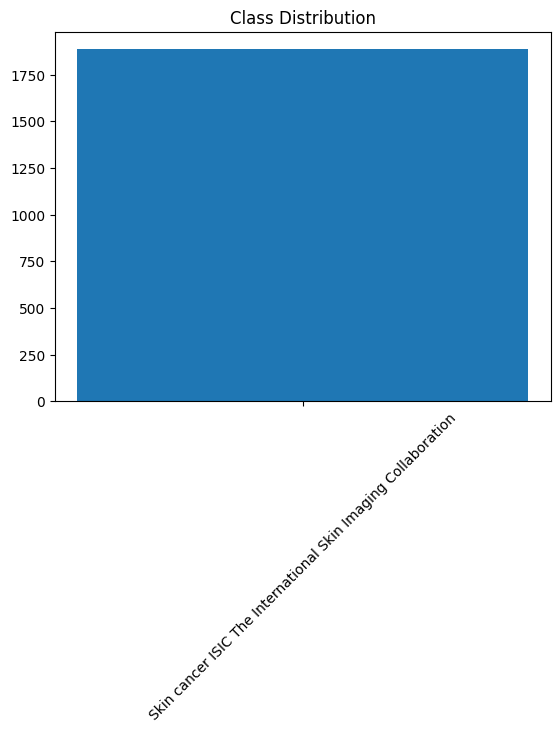

In [6]:
counts = {}

for _, labels in train_ds:
    for l in labels.numpy():
        counts[l] = counts.get(l, 0) + 1

plt.bar(class_names, counts.values())
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()


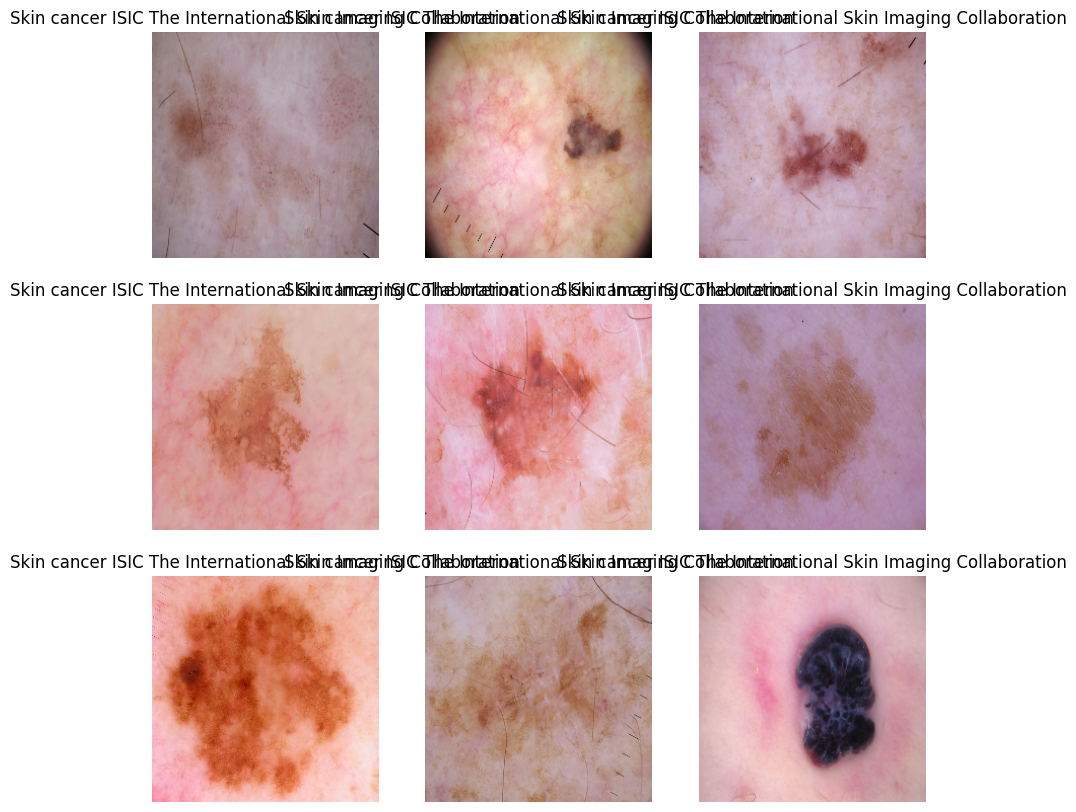

In [7]:
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [8]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])


In [10]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224,224,3)),
    data_augmentation,

    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64,3,activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128,3,activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(len(class_names),activation='softmax')
])

model.summary()


c:\Users\Hp\Documents\GitHub\Breast-canser_screening\.venv\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,244,929 (84.86 MB)

 Trainable params: 22,244,929 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10


c:\Users\Hp\Documents\GitHub\Breast-canser_screening\.venv\Lib\site-packages\keras\src\ops\nn.py:947: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


59/59 ━━━━━━━━━━━━━━━━━━━━ 251s 4s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 276s 4s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 213s 4s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 228s 4s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 212s 4s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/10

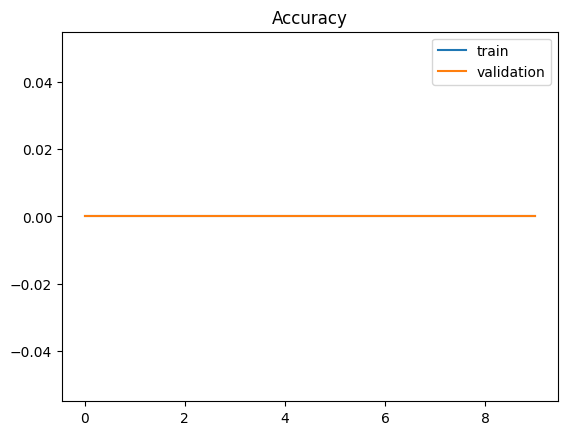

In [12]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["train","validation"])
plt.title("Accuracy")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

y_true = []
y_pred = []

for x,y in val_ds:
    pred = model.predict(x)
    y_true.extend(y.numpy())
    y_pred.extend(pred.argmax(axis=1))

print(classification_report(y_true,y_pred))


ModuleNotFoundError: No module named 'sklearn'

In [ ]:
model.save("breast_risk_model.h5")
